In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time
import math
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

with open('./data/flowers_cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['1'])
print(cat_to_name['4'])
print()
classes, c_2_idx = find_classes('./data/flowers/train/')
print(classes)
print(c_2_idx)
print()
cls_2_name = {}
idx_2_fld = {}

print(c_2_idx.keys())
print()
for k in c_2_idx.keys():
    cls = c_2_idx[str(k)]
    cls_2_name[int(cls)] = cat_to_name[str(k)]
    idx_2_fld[int(cls)] = str(k)
print(cls_2_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [3]:
   
# Note transforms.ToTensor() scales input images
# to 0-1 range

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor()
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                    std=[0.229, 0.224, 0.225] )
    ])

train_data_path = "./data/flowers/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms)

val_data_path = "./data/flowers/valid/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms)

batch_size=32
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

device = None 

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

print(('load data ---> done!'))

load data ---> done!


In [4]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
#print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
17


torch.Size([3, 224, 224])
tensor([ 4, 13, 16, 16,  5,  7, 15,  5,  8,  3, 14, 12,  8, 11,  1,  6,  4,  6,
        15, 16,  3, 12, 15,  2,  1,  4,  2, 11,  2,  5, 16, 14])


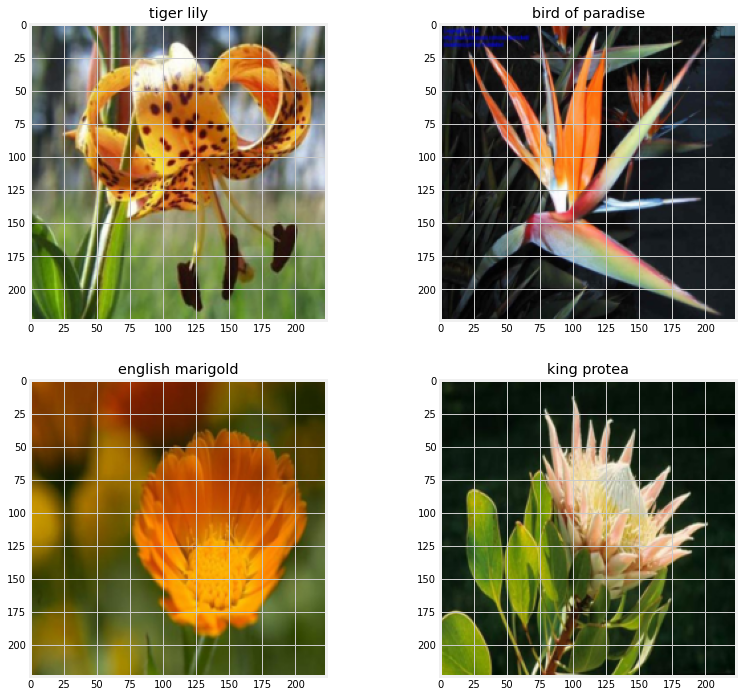

In [5]:
it = iter(train_data_loader)

dt,target = it.next()
print(dt[1].shape)
print(target)

# 显示图片
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
axes[0,0].title.set_text(cls_2_name[int(target[1].numpy())])
axes[0,1].imshow(dt[6].numpy().transpose(1, 2, 0))
axes[0,1].title.set_text(cls_2_name[int(target[6].numpy())])
axes[1,0].imshow(dt[11].numpy().transpose(1, 2, 0))
axes[1,0].title.set_text(cls_2_name[int(target[11].numpy())])
axes[1,1].imshow(dt[16].numpy().transpose(1, 2, 0))
axes[1,1].title.set_text(cls_2_name[int(target[16].numpy())])
plt.show()

In [13]:
################################
# network ShuffleNetV2
################################
class ShuffleBlock(nn.Module):
    def __init__(self, groups=2):
        super(ShuffleBlock, self).__init__()
        self.groups = groups

    def forward(self, x):
        '''Channel shuffle: [N,C,H,W] -> [N,g,C/g,H,W] -> [N,C/g,g,H,w] -> [N,C,H,W]'''
        N, C, H, W = x.size()
        g = self.groups
        return x.view(N, g, C//g, H, W).permute(0, 2, 1, 3, 4).reshape(N, C, H, W)


class SplitBlock(nn.Module):
    def __init__(self, ratio):
        super(SplitBlock, self).__init__()
        self.ratio = ratio

    def forward(self, x):
        c = int(x.size(1) * self.ratio)
        return x[:, :c, :, :], x[:, c:, :, :]


class BasicBlock(nn.Module):
    def __init__(self, in_channels, split_ratio=0.5):
        super(BasicBlock, self).__init__()
        self.split = SplitBlock(split_ratio)
        in_channels = int(in_channels * split_ratio)
        self.conv1 = nn.Conv2d(in_channels, in_channels,
                               kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels,
                               kernel_size=3, stride=1, padding=1, groups=in_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv3 = nn.Conv2d(in_channels, in_channels,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(in_channels)
        self.shuffle = ShuffleBlock()

    def forward(self, x):
        x1, x2 = self.split(x)
        out = F.relu(self.bn1(self.conv1(x2)))
        out = self.bn2(self.conv2(out))
        out = F.relu(self.bn3(self.conv3(out)))
        out = torch.cat([x1, out], 1)
        out = self.shuffle(out)
        return out


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        mid_channels = out_channels // 2
        # left
        self.conv1 = nn.Conv2d(in_channels, in_channels,
                               kernel_size=3, stride=2, padding=1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, mid_channels,
                               kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        # right
        self.conv3 = nn.Conv2d(in_channels, mid_channels,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(mid_channels)
        self.conv4 = nn.Conv2d(mid_channels, mid_channels,
                               kernel_size=3, stride=2, padding=1, groups=mid_channels, bias=False)
        self.bn4 = nn.BatchNorm2d(mid_channels)
        self.conv5 = nn.Conv2d(mid_channels, mid_channels,
                               kernel_size=1, bias=False)
        self.bn5 = nn.BatchNorm2d(mid_channels)

        self.shuffle = ShuffleBlock()

    def forward(self, x):
        # left
        out1 = self.bn1(self.conv1(x))
        out1 = F.relu(self.bn2(self.conv2(out1)))
        # right
        out2 = F.relu(self.bn3(self.conv3(x)))
        out2 = self.bn4(self.conv4(out2))
        out2 = F.relu(self.bn5(self.conv5(out2)))
        # concat
        out = torch.cat([out1, out2], 1)
        out = self.shuffle(out)
        return out


class ShuffleNetV2(nn.Module):
    def __init__(self, net_size, num_classes):
        super(ShuffleNetV2, self).__init__()
        out_channels = configs[net_size]['out_channels']
        num_blocks = configs[net_size]['num_blocks']

        self.conv1 = nn.Conv2d(3, 24, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.in_channels = 24
        self.layer1 = self._make_layer(out_channels[0], num_blocks[0])
        self.layer2 = self._make_layer(out_channels[1], num_blocks[1])
        self.layer3 = self._make_layer(out_channels[2], num_blocks[2])
        self.conv2 = nn.Conv2d(out_channels[2], out_channels[3],
                               kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels[3])
        self.linear = nn.Linear(out_channels[3], num_classes)

    def _make_layer(self, out_channels, num_blocks):
        layers = [DownBlock(self.in_channels, out_channels)]
        for i in range(num_blocks):
            layers.append(BasicBlock(out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


configs = {
    0.1: {
        'out_channels': (12, 24, 48, 96),
        'num_blocks': (1, 3, 1)
    },
    
    0.5: {
        'out_channels': (48, 96, 192, 1024),
        'num_blocks': (3, 7, 3)
    },

    1: {
        'out_channels': (116, 232, 464, 1024),
        'num_blocks': (3, 7, 3)
    },
    1.5: {
        'out_channels': (176, 352, 704, 1024),
        'num_blocks': (3, 7, 3)
    },
    2: {
        'out_channels': (224, 488, 976, 2048),
        'num_blocks': (3, 7, 3)
    }
}

net = ShuffleNetV2(net_size=0.1, num_classes=num_classes)
x = torch.randn(32,3,224,224)
y = net(x)
print(y.size())

torch.Size([32, 17])


In [14]:
model = ShuffleNetV2(net_size=0.1, num_classes=num_classes)
#print(model)

input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)

torch.Size([8, 17])


In [15]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu"):

    for epoch in range(epochs):
        
        print('---- Training ----')
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        print('---- Validating ----')
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {},  Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
            epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [16]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training model

In [17]:
# Training model

train(model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=10, device=device)

---- Training ----
---- Validating ----
Epoch: 1,  Training Loss: 2.79, Validation Loss: 2.84, accuracy = 0.01
---- Training ----
---- Validating ----
Epoch: 2,  Training Loss: 2.56, Validation Loss: 2.48, accuracy = 0.27
---- Training ----
---- Validating ----
Epoch: 3,  Training Loss: 2.30, Validation Loss: 2.29, accuracy = 0.28
---- Training ----
---- Validating ----
Epoch: 4,  Training Loss: 2.10, Validation Loss: 2.08, accuracy = 0.38
---- Training ----
---- Validating ----
Epoch: 5,  Training Loss: 1.89, Validation Loss: 1.98, accuracy = 0.38
---- Training ----
---- Validating ----
Epoch: 6,  Training Loss: 1.73, Validation Loss: 1.79, accuracy = 0.46
---- Training ----
---- Validating ----
Epoch: 7,  Training Loss: 1.55, Validation Loss: 1.67, accuracy = 0.48
---- Training ----
---- Validating ----
Epoch: 8,  Training Loss: 1.47, Validation Loss: 1.54, accuracy = 0.49
---- Training ----
---- Validating ----
Epoch: 9,  Training Loss: 1.33, Validation Loss: 1.44, accuracy = 0.44
-

### Test

In [18]:
test_data_path = "./data/flowers/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms)

batch_size=32
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

for batch in test_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    targets = targets.to(device)
    loss = loss_fn(output,targets) 
    test_loss += loss.data.item() * inputs.size(0)
    correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

print('Test Loss: {:.2f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

Test Loss: 1.44, accuracy = 0.56


tensor([ 5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11, 11])
tensor([ 1,  2,  1,  6,  7,  6, 15, 12,  7,  1,  8, 14,  8,  8,  8,  9,  8, 13,
         8,  9, 14, 11,  9,  9,  5, 10,  2, 11, 14, 16,  9,  9])


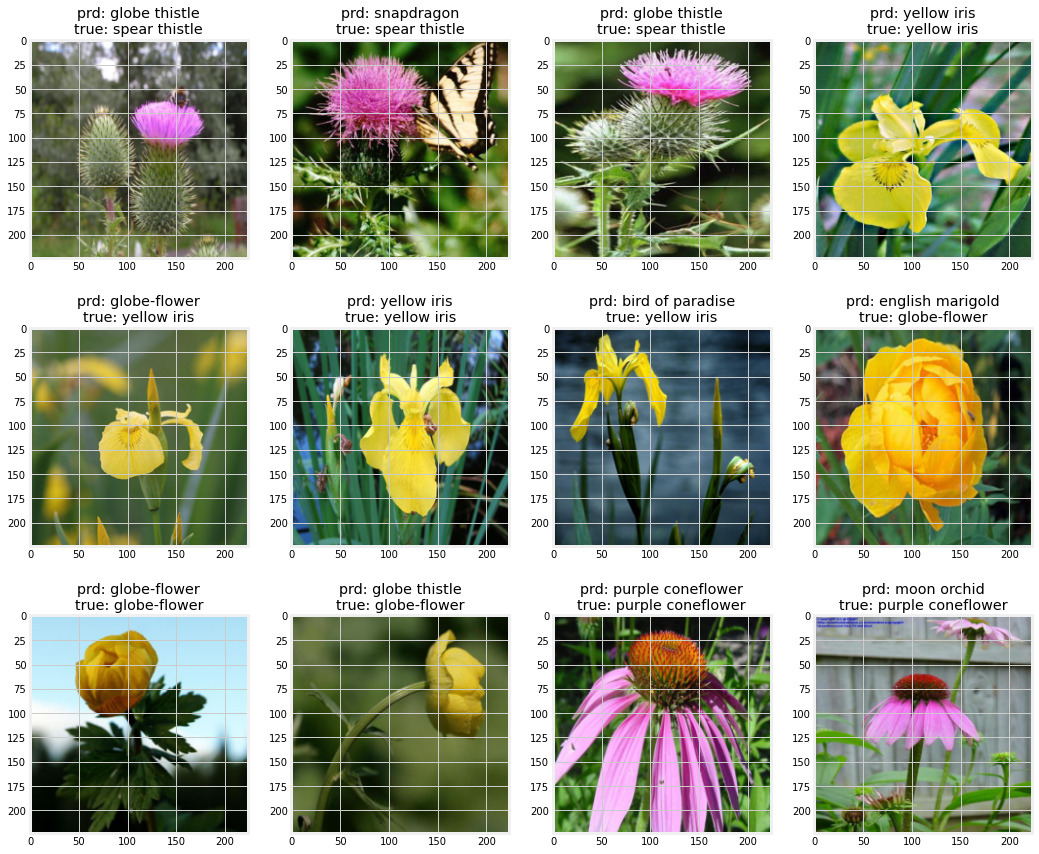

In [19]:
it = iter(test_loader)
it.next()
dt, labs = it.next()
dt = dt.to(device)
output = model(dt)
prd_labs = torch.max(F.softmax(output), dim=1)[1].view(-1)
print(labs)
print(prd_labs)

plt.figure(figsize=(16,15))
k = 0
for i in range(3):
    for j in range(4):
        ax = plt.subplot2grid((3,4), (i,j))
        #print(dt[k].numpy().transpose((1, 2, 0)).shape)
        tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + '\ntrue: ' + cls_2_name[int(labs[k].numpy())]
        ax.imshow(dt[k].numpy().transpose((1, 2, 0)))
        ax.title.set_text(tlt)
        #ax.scatter(range(20),range(20)+np.random.randint(-5,5,20))
        k = k + 1
plt.show()